# Differential error resampling analysis

Here we use the synthetic MALAT1 reads and the Arabidopsis reads in a bootstrapped resampling experiment to see how many reads are required to identify an m6A site.

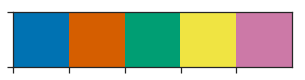

In [1]:
import re
import sys
import os
from glob import glob
import random
from collections import Counter, defaultdict
from itertools import chain

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from joblib import Parallel, delayed
import pysam

from differr.pileups import get_reference_pos, get_query_seqs, parse_query
from differr.main import filter_by_expression
from differr.statistics import test_significant_der_sites

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [102]:
# We have to modify these methods slightly to allow random subsampling

COLUMNS = ['A', 'C', 'G', 'T', 'indel']

def iter_pileupreads(pileupcol):
    '''
    Generator yielding strand and query sequence for reads in pileupcol
    Reads which are refskip (i.e. intronic) are skipped
    '''
    query_seqs = get_query_seqs(pileupcol)
    for read, seq in zip(pileupcol.pileups, query_seqs):
        if not read.is_refskip:
            is_reverse = read.alignment.is_reverse
            read_id = read.alignment.query_name
            yield is_reverse, seq, read_id


def get_read_id_subsamples(bam, query, k, n):
    read_ids = set()
    for aln in bam.fetch(*query):
        read_ids.add(aln.query_name)
    read_id_subsamples = []
    for _ in range(n):
        read_id_subsamples.append(set(random.sample(read_ids, k=min(k, len(read_ids)))))
    return read_id_subsamples


def count_mismatches(col, read_id_subsamples):
    '''
    For a pysam PileupColumn, computes the number of reads
    which contain each base or indels and returns a df
    '''
    ref_name, ref_pos = get_reference_pos(col)
    refs = [(ref_name, ref_pos, '+'),
            (ref_name, ref_pos, '-')]
    counts = [{r: Counter() for r in refs} for _ in range(len(read_id_subsamples))]
    for is_reverse, query_seq_type, read_id in iter_pileupreads(col):
        for i, ss in enumerate(read_id_subsamples):
            if read_id in ss:
                strand = refs[is_reverse]
                counts[i][strand][query_seq_type] += 1
    return counts


def process_bam(bam_fn, sample_size, n_subsamples, query, max_depth=10_000_000):
    '''
    Open a bam file and get the base counts for a query.
    Designed to be called in parallel on a number of
    bams at once (hence why we have to reopen the bam
    for every query chunk we process).
    '''
    with pysam.AlignmentFile(bam_fn) as bam:
        chunk_res = [{} for _ in range(n_subsamples)]
        read_id_subsamples = get_read_id_subsamples(bam, query, sample_size, n_subsamples)
        for col in bam.pileup(
                *query,
                max_depth=max_depth,
                truncate=True, min_base_quality=0):
            res = count_mismatches(col, read_id_subsamples)
            for i, r in enumerate(res):
                chunk_res[i].update(r)
    chunk_res = [
        pd.DataFrame.from_dict(cr, orient='index', columns=COLUMNS).fillna(0)
        for cr in chunk_res
    ]
    return chunk_res


def run_differr_analysis_with_sampling(cntrl_bam_fns, kd_bam_fns,
                                       fasta_fn, query,
                                       subsample_size, n_subsamples, n_procs):
    with Parallel(n_jobs=n_procs) as pool:
        query = parse_query(query)
        all_subsample_counts = pool(
            delayed(process_bam)(
                bam_fn, subsample_size, n_subsamples, query)
            for bam_fn in chain(kd_bam_fns, cntrl_bam_fns)
        )
    all_subsample_res = []
    for i in range(n_subsamples):
        counts = {
            'kd': pd.concat([x[i] for x in all_subsample_counts[:len(kd_bam_fns)]],
                            axis=1, keys=range(len(kd_bam_fns))),
            'cntrl': pd.concat([x[i] for x in all_subsample_counts[len(kd_bam_fns):]],
                               axis=1, keys=range(len(cntrl_bam_fns))),
        }
        counts = pd.concat(counts, axis=1, join='inner').fillna(0)
        counts = filter_by_expression(counts, 0, 1)
        with pysam.FastaFile(fasta_fn) as fasta:
            results, mismatch_counts = test_significant_der_sites(counts, 0.05, fasta)
        _, results['hetero_G_fdr'], *_ = multipletests(results.hetero_G_pval.fillna(1), method='fdr_bh')
        all_subsample_res.append(results.query('hetero_G_fdr < 0.05 & mismatch_odds_ratio > 1'))
    return all_subsample_res


def run_differr_analysis_with_partial_mod(cntrl_bam_fn, kd_bam_fn, 
                                          fasta_fn, subsample_size,
                                          n_subsamples, 
                                          modified_fraction=1):
    query = (None, None, None)
    cntrl_subsample_size = int(subsample_size * modified_fraction)
    cntrl_subsample_size_unmod = subsample_size - cntrl_subsample_size
    kd_sample_counts = process_bam(kd_bam_fn, subsample_size, n_subsamples, query)
    cntrl_sample_counts = process_bam(cntrl_bam_fn, cntrl_subsample_size, n_subsamples, query)
    if cntrl_subsample_size_unmod:
        cntrl_sample_counts_unmod = process_bam(
            kd_bam_fn, cntrl_subsample_size_unmod, n_subsamples, query
        )
        for i in range(n_subsamples):
            cntrl_sample_counts[i] = cntrl_sample_counts[i].add(
                cntrl_sample_counts_unmod[i], fill_value=0
            )
    all_subsample_res = []
    for i in range(n_subsamples):
        counts = {
            'kd': pd.concat([kd_sample_counts[i],], axis=1, keys=[0,]),
            'cntrl': pd.concat([cntrl_sample_counts[i],], axis=1, keys=[0,]),
        }
        counts = pd.concat(counts, axis=1, join='inner').fillna(0)
        counts = filter_by_expression(counts, 0, 1)
        with pysam.FastaFile(fasta_fn) as fasta:
            results, mismatch_counts = test_significant_der_sites(counts, 0.05, fasta)
        _, results['hetero_G_fdr'], *_ = multipletests(results.hetero_G_pval.fillna(1), method='fdr_bh')
        all_subsample_res.append(results.query('hetero_G_fdr < 0.05 & mismatch_odds_ratio > 1'))
    return all_subsample_res

In [3]:
MALAT1_CNTRL = '/cluster/ggs_lab/mtparker/DER_m6a_pipeline_runs/MALAT1/alignments/20171214_MALAT1_cntrl.bam'
MALAT1_M6A = '/cluster/ggs_lab/mtparker/DER_m6a_pipeline_runs/MALAT1/alignments/20171218_MALAT1_m6A.bam'
MALAT1_FASTA = '/cluster/ggs_lab/mtparker/DER_m6a_pipeline_runs/MALAT1/MALAT1_fragment.fa'

In [120]:
subsample_sizes = np.arange(10, 251, 10)
res = {}
with Parallel(n_jobs=20) as pool:
    for modified_frac in (0.25, 0.5, 0.75, 1):
        res[modified_frac] = pool(delayed(run_differr_analysis_with_partial_mod)(
            MALAT1_CNTRL, MALAT1_M6A, MALAT1_FASTA, ssize, 500, modified_frac)
                                  for ssize in subsample_sizes)

In [121]:
POS = range(36, 45)
agg_res = defaultdict(list)

for modified_frac in res.keys():
    for boots in res[modified_frac]:
        s = [np.isin(POS, b.pos.values).any() for b in boots]
        agg_res[modified_frac].append(sum(s))

In [132]:
subsample_sizes[np.argwhere(np.array(agg_res[1]) >= (500 * 0.95))[0][0]]

60

In [131]:
subsample_sizes[np.argwhere(np.array(agg_res[0.5]) >= (500 * 0.95))[0][0]]

200

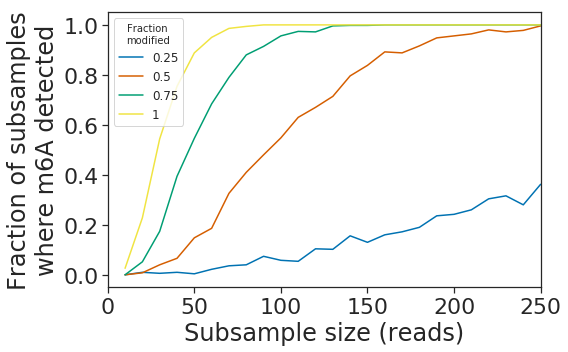

In [133]:
fig, ax = plt.subplots(figsize=(8, 5))
for mf, r in agg_res.items():
    ax.plot(subsample_sizes, np.array(r) / 500, label=mf)
ax.set_xlim(0, 250)
ax.set_xlabel('Subsample size (reads)')
ax.set_ylabel('Fraction of subsamples\nwhere m6A detected')
ax.legend(title='Fraction\nmodified', fontsize=12)
plt.tight_layout()
plt.savefig('MALAT1_bootstrap_res.svg')
plt.show()

In [134]:
KD_BAMS = glob('/cluster/ggs_lab/mtparker/DER_m6a_pipeline_runs/vir1_VIRc_guppy/alignments/*vir1*.bam')
CNTRL_BAMS = glob('/cluster/ggs_lab/mtparker/DER_m6a_pipeline_runs/vir1_VIRc_guppy/alignments/*VIRc*.bam')
FASTA_FN = '/cluster/ggs_lab/mtparker/Arabidopsis_annotations/TAIR10/ensembl/release_35/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa'

In [135]:
METHYLATED_GENES = {
    'AT1G10360': '1:3395525-3396893',
    'AT1G62180': '1:22975462-22977846',
    'AT3G62580': '3:23146806-23147992',
}

METHYLATION_SITES = {
    'AT1G10360': [
        ('1', 3395590, 3395597),
    ],
    'AT1G62180': [
        ('1', 22975627, 22975634),
    ],
    'AT3G62580': [
        ('3', 23147838, 23147845),
        ('3', 23147845, 23147852)
    ]
}

In [ ]:
subsample_sizes = np.arange(5, 101, 5)
res = defaultdict(lambda: defaultdict(list))
for gene_id, query in METHYLATED_GENES.items():
    for sample_size in subsample_sizes:
        try:
            res[gene_id][sample_size].append(
                run_differr_analysis_with_sampling(
                    CNTRL_BAMS, KD_BAMS, FASTA_FN,
                    query, sample_size, 500, n_procs=8)
            )
        except ValueError:
            break

In [ ]:
agg_res = {}
for gene_id in METHYLATED_GENES:
    msites = METHYLATION_SITES[gene_id]
    gene_agg_res = defaultdict(list)
    for chrom, start, end in msites:
        pos = range(start, end)
        for boots in res[gene_id].values():
            if boots:
                s = [np.isin(pos, b.pos.values).any() for b in boots[0]]
                gene_agg_res[f'{chrom}:{start}-{end}'].append(sum(s))
    agg_res[gene_id] = gene_agg_res

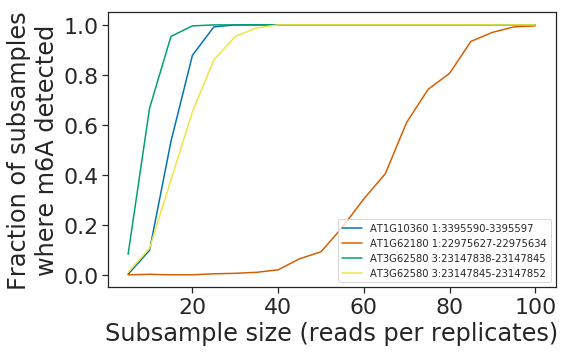

In [151]:
fig, ax = plt.subplots(figsize=(8, 5))
for gene_id, r in agg_res.items():
    for inv, n in r.items():
        ax.plot(subsample_sizes[:len(n)], np.array(n) / 500, label=f'{gene_id} {inv}')
plt.legend(fontsize=10)
ax.set_xlabel('Subsample size (reads per replicates)')
ax.set_ylabel('Fraction of subsamples\nwhere m6A detected')
plt.tight_layout()
plt.savefig('arabidopsis_bootstrap_res.svg')
plt.show()